## Create data for unit testing of `solardatatools.signal_decompositions`
## Test module `test_signal_decompositions` (updated OSD version)

## `l2_l1d1_l2d2p365`

Components:
- l2: gaussian noise, sum-of-squares small or l2-norm squared
- l1d1: piecewise constant heuristic, l1-norm of first order differences
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests:
- test_l2_l1d1_l2d2p365_default
- test_l2_l1d1_l2d2p365_default_long
- test_l2_l1d1_l2d2p365_idx_select
- test_l2_l1d1_l2d2p365_yearly_periodic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
import random
import json

from utils import plot_decomp, plot_signal
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

In [2]:
%load_ext autoreload
%autoreload 2

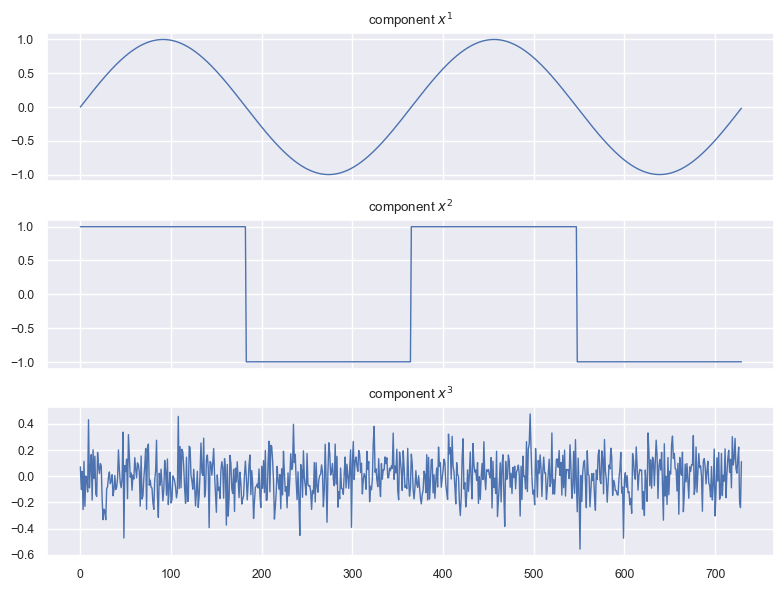

In [3]:
# Full length test signal used for this function l2_l1d1_l2d2p365
t = np.arange(365*2)

signal1 = np.sin(2 * np.pi * t * 1 / (365.))  
signal2 = signal.square(2 * np.pi * t * 1 / (365.)) 
signal3 = 0.15 * np.random.randn(len(signal1))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

### `test_l2_l1d1_l2d2p365_default`

0.019124844822600566


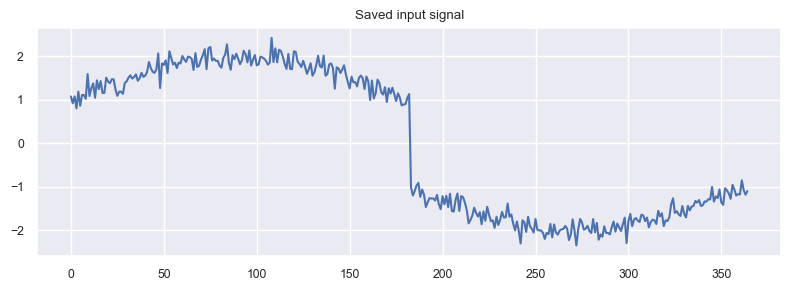

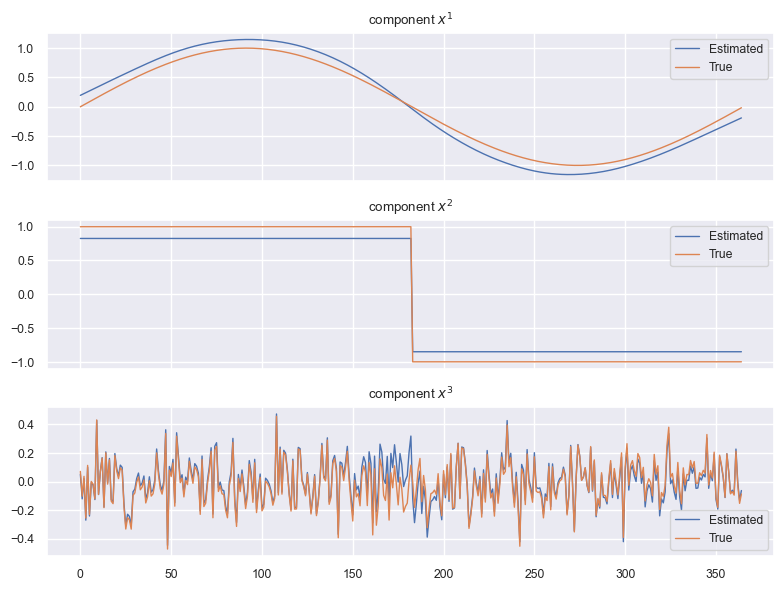

In [6]:
# Input
# Take signal <365 
signal_365 = y[:365]
X_real_365 = [x[:365] for x in X_real]

input_dict = {
    "test_signal": list(signal_365)
}

with open("test_l2_l1d1_l2d2p365_default_input.json", "w") as outfile:
    json.dump(input_dict, outfile)
    
plot_signal(signal_365);
plt.title("Saved input signal");

# Output
s_hat, s_seas, s_error, problem = sd.l2_l1d1_l2d2p365(signal_365, w1=50, w2=1e6, solver="QSS", return_all=True)

obj_val = problem.objective_value

print(obj_val)
output_dict = {
    "expected_s_hat_365": list(s_hat),
    "expected_s_seas_365": list(s_seas),
    "expected_obj_val_365": obj_val
}

with open("test_l2_l1d1_l2d2p365_default_output.json", "w") as outfile:
    json.dump(output_dict, outfile)
    
plot_decomp([s_seas, s_hat, s_error], X_real_365)

### `test_l2_l1d1_l2d2p365_default_long`

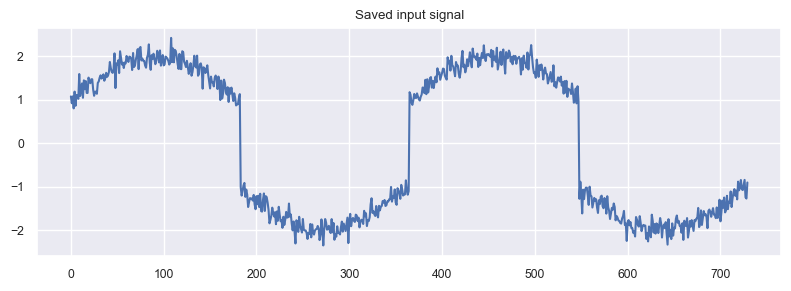

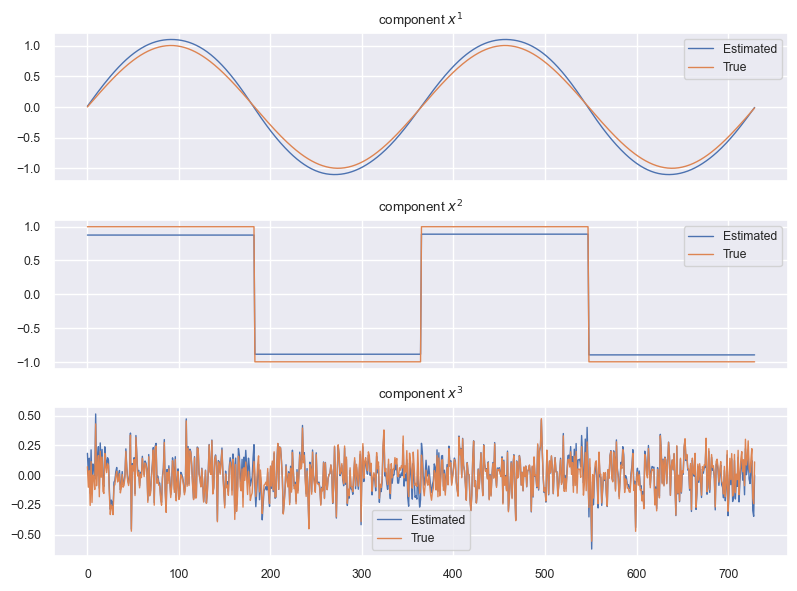

In [12]:
# Input
# taking full length signal
signal_730 = y

## input
input_dict = {
    "test_signal": list(signal_730)
}

with open("test_l2_l1d1_l2d2p365_default_long_input.json", "w") as outfile:
    json.dump(input_dict, outfile)

plot_signal(signal_730);


# Output
s_hat, s_seas, s_error, problem = sd.l2_l1d1_l2d2p365(signal_730, w1=50, w2=1e6, solver="QSS", return_all=True)

obj_val = problem.objective_value

output_dict = {
    "expected_s_hat": list(s_hat),
    "expected_s_seas": list(s_seas),
    "expected_obj_val": obj_val
}

with open("test_l2_l1d1_l2d2p365_default_long_output.json", "w") as outfile:
    json.dump(output_dict, outfile)

plot_decomp([s_seas, s_hat, s_error], X_real)

### `test_l2_l1d1_l2d2p365_idx_select`

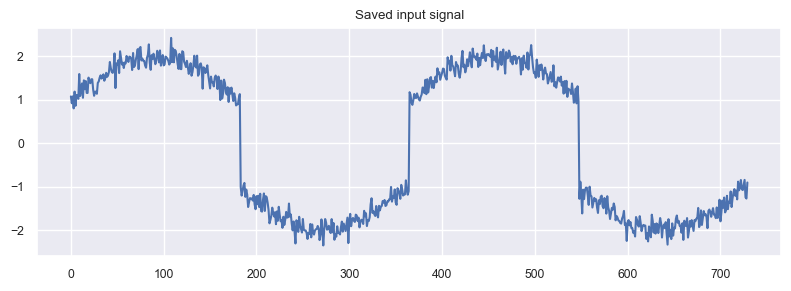

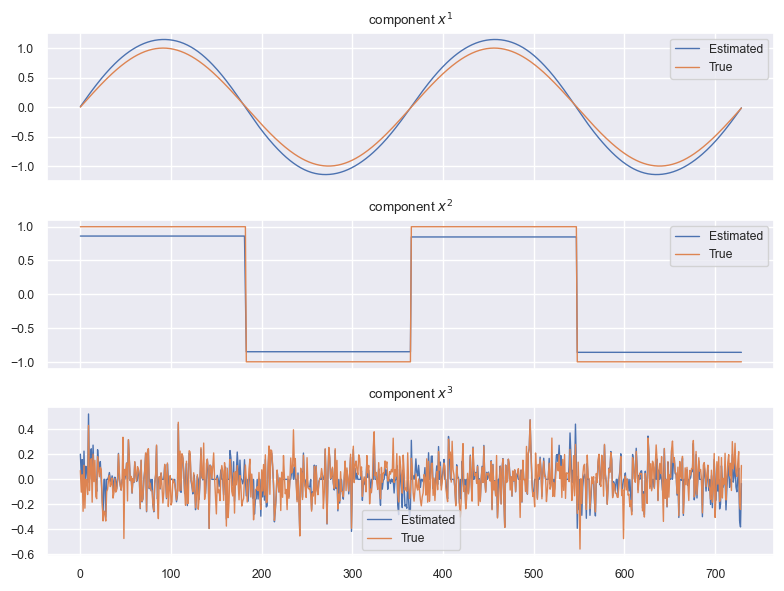

In [18]:
# Input
# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

## input
input_dict = {
    "test_signal": list(signal_730),
    "indices": list(indices)
}

with open("test_l2_l1d1_l2d2p365_idx_select_input.json", "w") as outfile:
    json.dump(input_dict, outfile)

plot_signal(signal_730)


# Output
s_hat, s_seas, s_error, problem = sd.l2_l1d1_l2d2p365(signal_730, w1=50, w2=1e6, solver="QSS", return_all=True,
                                                      use_ixs=indices)
    
obj_val = problem.objective_value

output_dict = {
    "expected_s_hat_ixs": list(s_hat),
    "expected_s_seas_ixs": list(s_seas),
    "expected_obj_val_ixs": obj_val
}

with open("test_l2_l1d1_l2d2p365_idx_select_output.json", "w") as outfile:
    json.dump(output_dict, outfile)

plot_decomp([s_seas, s_hat, s_error], X_real)

### `test_l2_l1d1_l2d2p365_yearly_periodic`

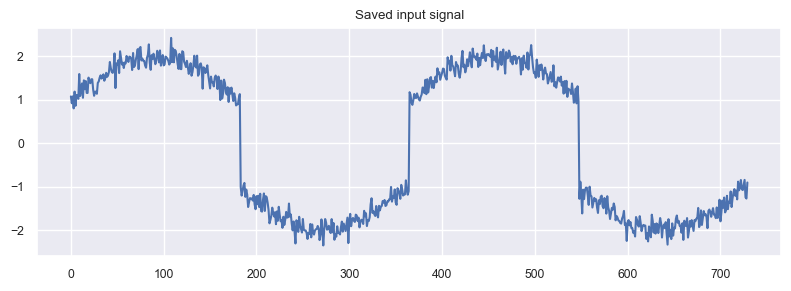

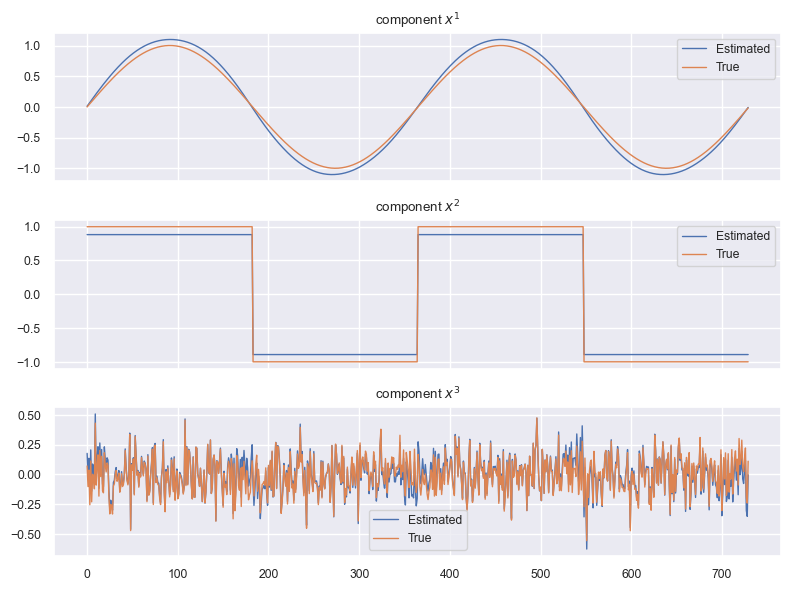

In [19]:
# Input
# yearly periodic constraint, len has to be >365
input_dict = {
    "test_signal": list(signal_730)
}

with open("test_l2_l1d1_l2d2p365_yearly_periodic_input.json", "w") as outfile:
    json.dump(input_dict, outfile)

plot_signal(signal_730);


# Output
s_hat, s_seas, s_error, problem = sd.l2_l1d1_l2d2p365(signal_730, w1=50, w2=1e6, solver="QSS", return_all=True,
                                                      yearly_periodic=True)

obj_val = problem.objective_value

output_dict = {
    "expected_s_hat_yearly_periodic": list(s_hat),
    "expected_s_seas_yearly_periodic": list(s_seas),
    "expected_obj_val_yearly_periodic": obj_val
}

with open("test_l2_l1d1_l2d2p365_yearly_periodic_output.json", "w") as outfile:
    json.dump(output_dict, outfile)

plot_decomp([s_seas, s_hat, s_error], X_real)

# ------------------------------------------------------------

## `tl1_l2d2p365`

Components:

- tl1: 'tilted l1-norm,' also known as quantile cost function
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests:
- test_tl1_l2d2p365_default
- test_tl1_l2d2p365_idx_select
- test_tl1_l2d2p365_long_not_yearly_periodic

In [20]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import laplace_asymmetric
import random
import json

from utils import plot_decomp, plot_signal
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

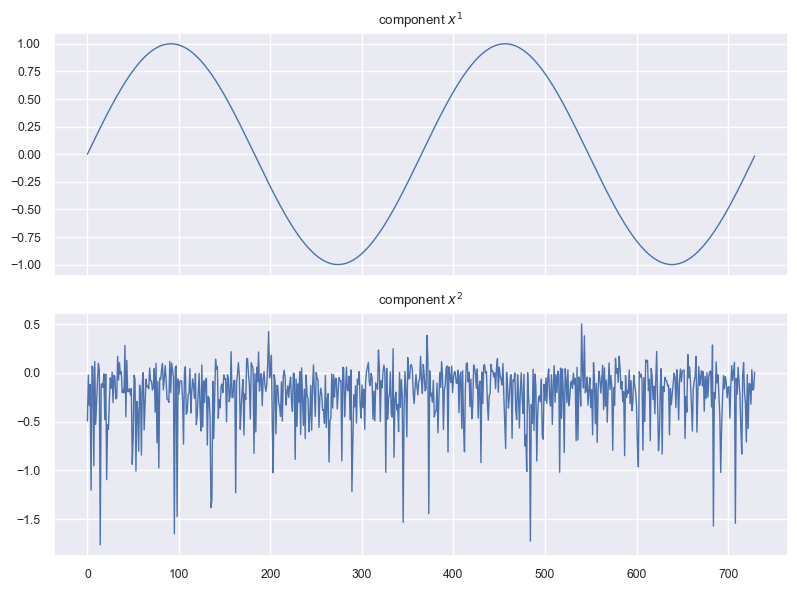

In [22]:
t = np.arange(365*2)

# seasonal periodic
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# asymmetric laplacian noise
kappa = 2 # k>0, k=1 is laplace
signal2 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2

y = np.sum(X_real, axis=0)
plot_decomp(X_real)

(array([  5.,   4.,   5.,  16.,  38.,  77., 171., 324.,  84.,   6.]),
 array([-1.76087584, -1.53489194, -1.30890805, -1.08292415, -0.85694026,
        -0.63095637, -0.40497247, -0.17898858,  0.04699532,  0.27297921,
         0.49896311]),
 <BarContainer object of 10 artists>)

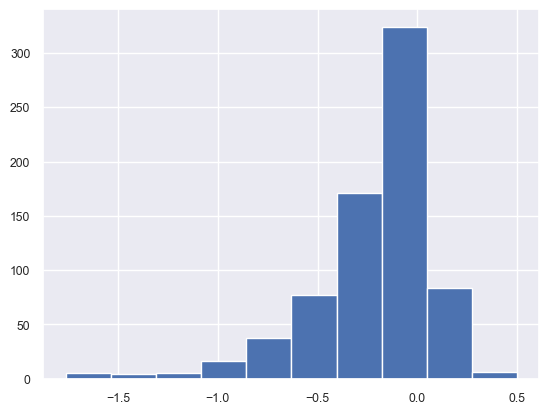

In [23]:
plt.hist(signal2)

In [24]:
np.quantile(signal2, 0.8) 

0.006092775222533824

#### -> switch to tau=0.8

### `test_tl1_l2d2p365_default`

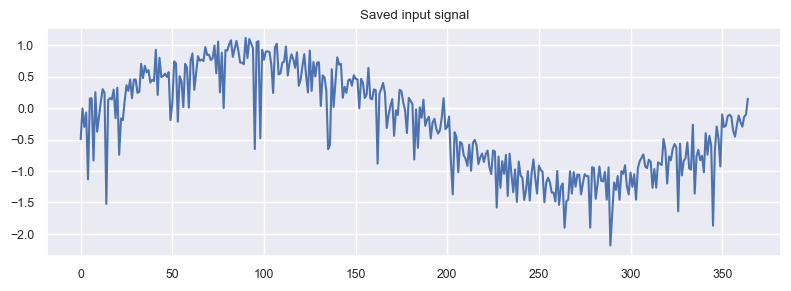

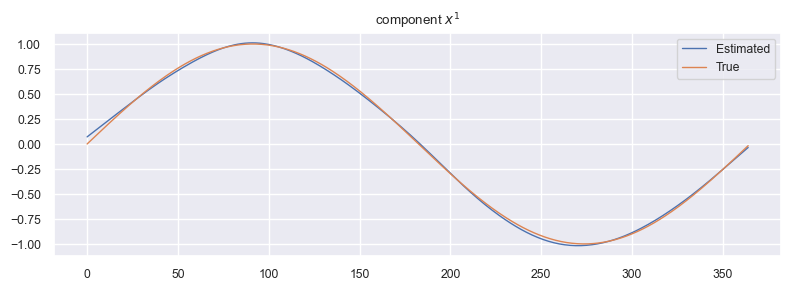

In [25]:
# Input
# Take signal <365 
signal_365 = y[:365]
X_real_365 = [x[:365] for x in X_real]

input_dict = {
    "test_signal": list(signal_365)
}

with open("test_tl1_l2d2p365_default_input.json", "w") as outfile:
    json.dump(input_dict, outfile)
    
plot_signal(signal_365);


# Output
s_seas, problem = sd.tl1_l2d2p365(signal_365, tau=0.8, w1=1e5, solver = "QSS", return_all=True)

obj_val = problem.objective_value

output_dict = {
    "expected_s_seas_365": list(s_seas),
    "expected_obj_val_365": obj_val
}

with open("test_tl1_l2d2p365_default_output.json", "w") as outfile:
    json.dump(output_dict, outfile)
    
plot_decomp([s_seas], [X_real_365[0]])

### `test_tl1_l2d2p365_idx_select`

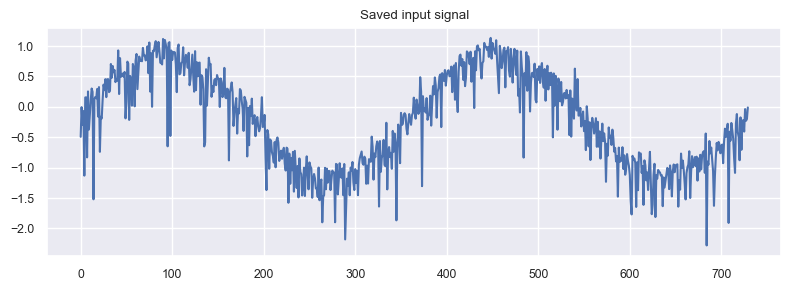

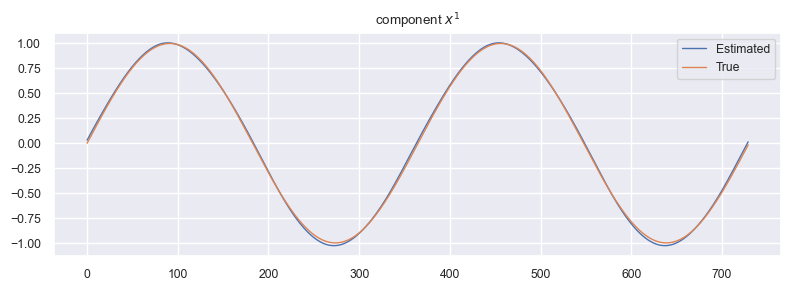

In [26]:
# Input
# Taking full length signal
signal_730 = y

# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

## input
input_dict = {
    "test_signal": list(signal_730),
    "indices": list(indices)
}

with open("test_tl1_l2d2p365_idx_select_input.json", "w") as outfile:
    json.dump(input_dict, outfile)
    
plot_signal(signal_730);


# Output
s_seas, problem = sd.tl1_l2d2p365(signal_730, tau=0.8, w1=1e5, solver = "QSS", use_ixs=indices, return_all=True)

obj_val = problem.objective_value

output_dict = {
    "expected_s_seas_ixs": list(s_seas),
    "expected_obj_val_ixs": obj_val
}
with open("test_tl1_l2d2p365_idx_select_output.json", "w") as outfile:
    json.dump(output_dict, outfile)

plot_decomp([s_seas], [X_real[0]])

### `test_tl1_l2d2p365_long_not_yearly_periodic`

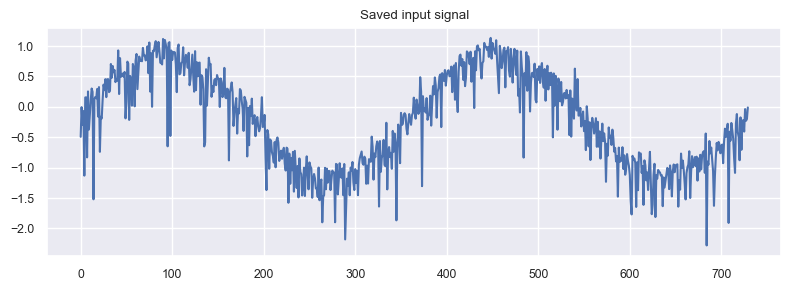

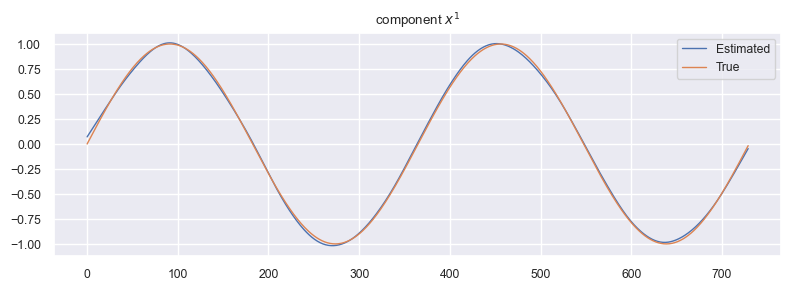

In [27]:
# Input
# Not yearly periodic and >365
input_dict = {
    "test_signal": list(signal_730)
}

with open("test_tl1_l2d2p365_long_not_yearly_periodic_input.json", "w") as outfile:
    json.dump(input_dict, outfile)
    
plot_signal(signal_730);


# Output
s_seas, problem = sd.tl1_l2d2p365(signal_730, solver = "QSS", tau=0.8, w1=1e5, yearly_periodic=False, return_all=True)

obj_val = problem.objective_value

output_dict = {
    "expected_s_seas_yearly_periodic": list(s_seas),
    "expected_obj_val_yearly_periodic": obj_val
}

with open("test_tl1_l2d2p365_long_not_yearly_periodic_output.json", "w") as outfile:
    json.dump(output_dict, outfile)

plot_decomp([s_seas], [X_real[0]])

# ------------------------------------------------------------


## `l1_l1d1_l2d2p365`

Components:
- l1: l1-norm
- l1d1: piecewise constant heuristic, l1-norm of first order differences
- l2d2p365: small second order diffs (smooth) and 365-periodic

Tests:
- test_l1_l1d1_l2d2p365_default
- test_l1_l1d1_l2d2p365_idx_select

In [28]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.stats import laplace_asymmetric
import random
import json

from utils import plot_decomp, plot_signal
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

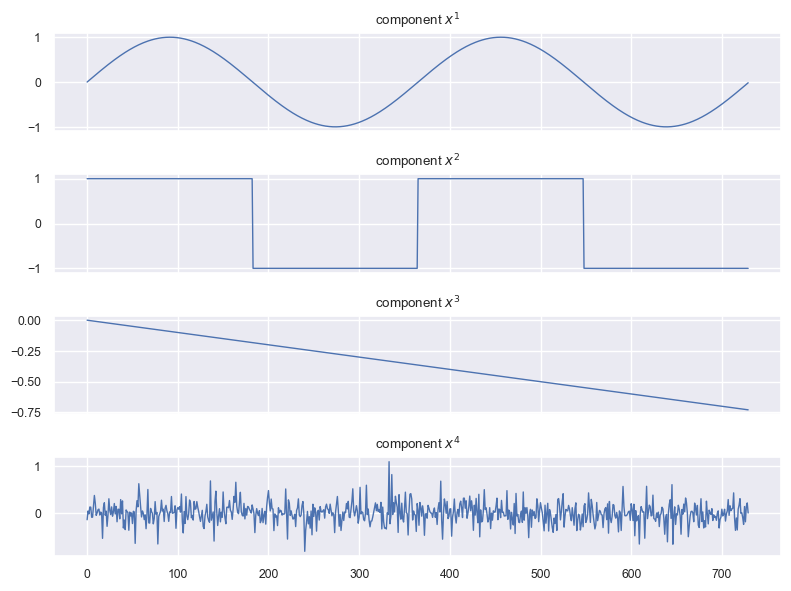

In [91]:
t = np.arange(365*2)

# seasonal term
signal1 = np.sin(2 * np.pi * t * 1 / (365.))
# piecewise constant term
signal2 = signal.square(2 * np.pi * t * 1 / (365.))
# asymmetric laplace noise 
kappa = 1 # k>0, k=1 is laplace
signal3 = 0.15 * laplace_asymmetric.rvs(kappa, size=len(signal1))

signal4 = -1e-3*t

X_real = np.zeros((4, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal4
X_real[3] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

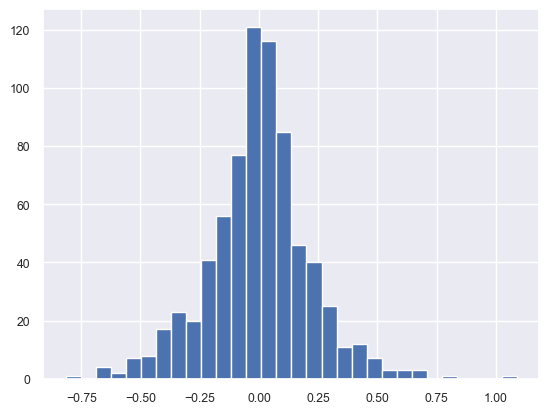

In [92]:
plt.hist(signal3, bins=30);

### `test_l1_l1d1_l2d2p365_default`

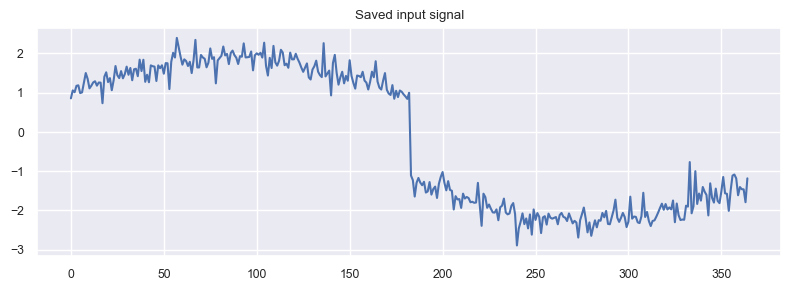

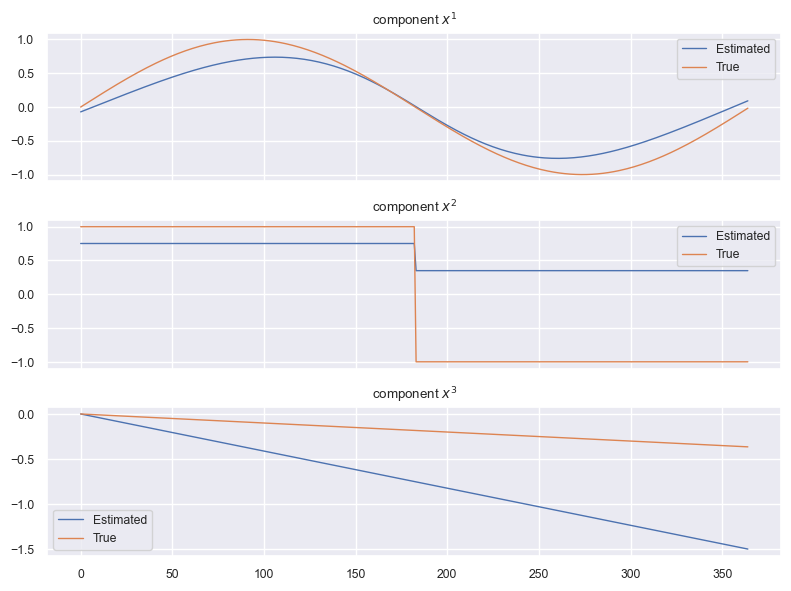

In [180]:
# Input
# Take signal <365 for this test
signal_365 = y[:365]
X_real_365 = [x[:365] for x in X_real]
input_dict = {
    "test_signal": list(signal_365)
}

with open("test_l1_l1d1_l2d2p365_default_input.json", "w") as outfile:
    json.dump(input_dict, outfile)

plot_signal(signal_365);


# Output
# c1 is tilted l1 param
s_hat, s_seas, s_lin, problem = sd.l1_l1d1_l2d2p365(signal_365,  w0=1e-10, w1=10e-7, w2=1e-2, w3=1, sum_card=True, solver = "QSS", return_all=True)

obj_val = problem.objective_value

output_dict = {
    "expected_s_hat_365": list(s_hat),
    "expected_s_seas_365": list(s_seas),
    "expected_s_lin_365": list(s_lin),
    "expected_obj_val_365": obj_val
}

with open("test_l1_l1d1_l2d2p365_default_output.json", "w") as outfile:
    json.dump(output_dict, outfile)
    
plot_decomp([s_seas, s_hat, s_lin], X_real_365)

### `test_l1_l1d1_l2d2p365_idx_select`

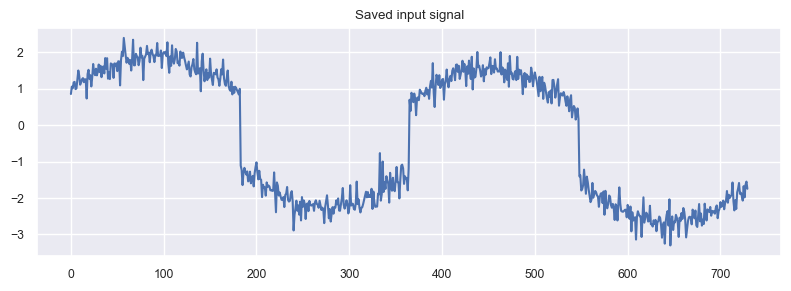

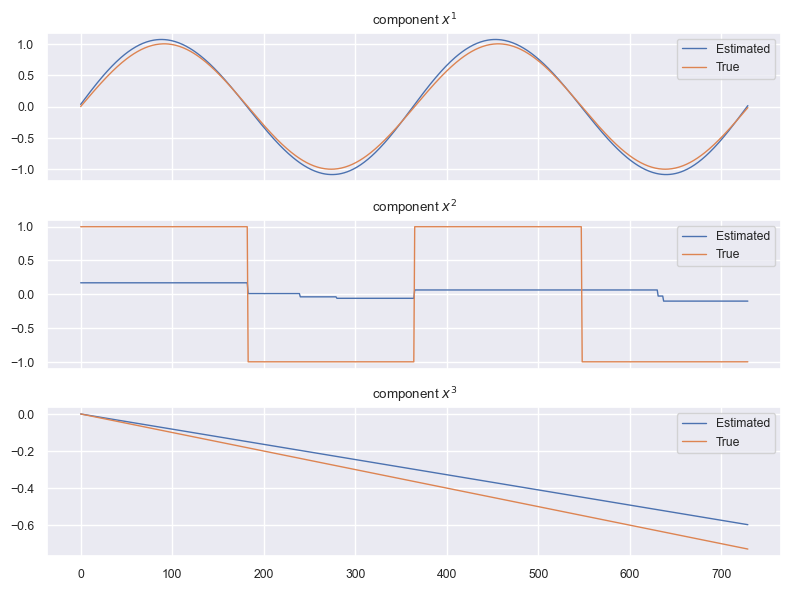

In [181]:
# Input
# Taking full length signal
signal_730 = y

# Take a random set of 500 indices
rand_set = random.sample(range(0, 730), 500)
indices = [True if i in rand_set else False for i in range(len(signal_730))]

input_dict = {
    "test_signal": list(signal_730),
    "indices": list(indices)
}

with open("test_l1_l1d1_l2d2p365_idx_select_input.json", "w") as outfile:
    json.dump(input_dict, outfile)
    
plot_signal(signal_730);


# Output
s_hat, s_seas, s_lin, problem = sd.l1_l1d1_l2d2p365(signal_730, 
                                                          solver = "QSS",                                            
                                                            w0=1e-10, w1=10e-7, w2=1e-2, w3=1, sum_card=True,
                                                          use_ixs=indices, 
                                                          return_all=True
                                                         )
obj_val = problem.objective_value

output_dict = {
    "expected_s_hat_ixs": list(s_hat),
    "expected_s_seas_ixs": list(s_seas),
    "expected_obj_val_ixs": obj_val
}

with open("test_l1_l1d1_l2d2p365_idx_select_output.json", "w") as outfile:
    json.dump(output_dict, outfile)
    

plot_decomp([s_seas, s_hat, s_lin], X_real)

# ------------------------------------------------------------


## `make_l2_l1d2_constrained`

Tests:
- test_make_l2_l1d2_default


In [183]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [184]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import json

from utils import plot_decomp, plot_signal
from solardatatools import signal_decompositions as sd

np.random.seed(12) 
random.seed(10)

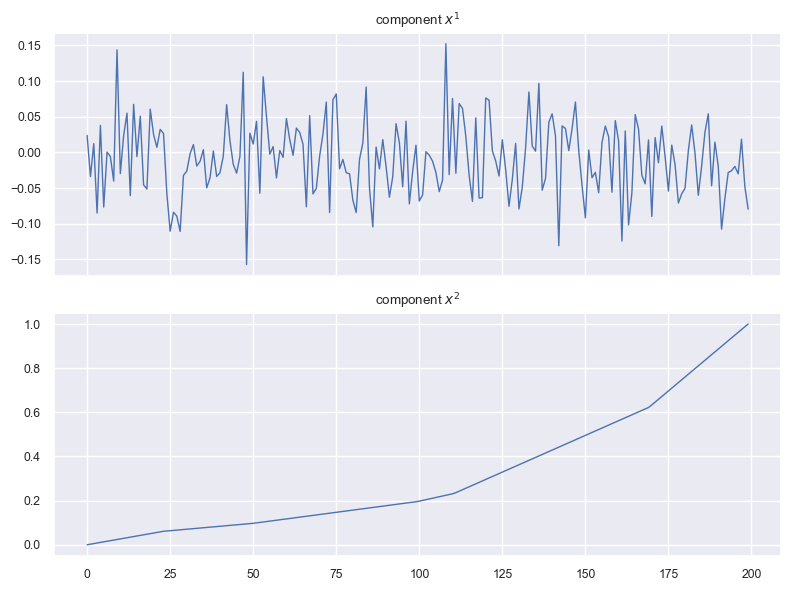

In [185]:
a = 4
b = [-2, 1, 2, 5, 9]
bpts = [23, 50, 100, 111, 170]
n_points = 200

noise = 0.05

x = np.linspace(0, 200, n_points)

y_points = a*x
for i in range(len(b)):
    y_points += b[i] * np.maximum(x - bpts[i], 0)
    
# normalize
y_points = (y_points-np.min(y_points))/(np.max(y_points)-np.min(y_points))

X_real = np.zeros((2, len(y_points)), dtype=float)
X_real[0] = np.random.normal(size=n_points) * noise
X_real[1] = y_points

y = np.sum(X_real, axis=0)

plot_decomp(X_real)

## `test_make_l2_l1d2_default_constrained`

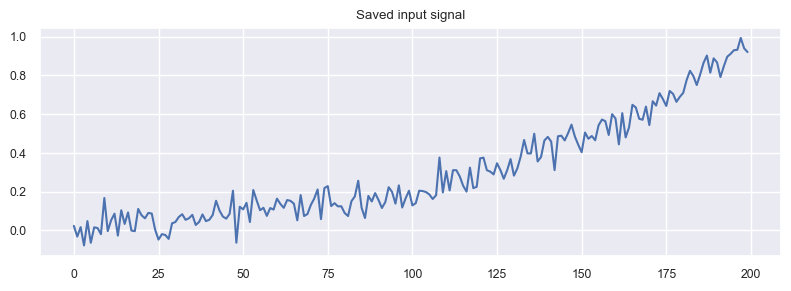

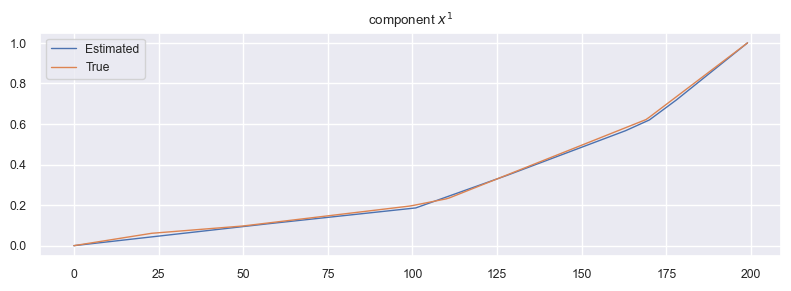

In [187]:
signal = y

input_dict = {
    "test_signal": list(signal)
}

with open("test_make_l2_l1d2_default_input.json", "w") as outfile:
    json.dump(input_dict, outfile)
    
plot_signal(signal);


# Output
problem, _, s_hat, _ = sd.make_l2_l1d2_constrained(signal, w1=5, solver = "QSS")

obj_val = problem.objective_value

output_dict = {
    "expected_y_hat": list(s_hat),
    "expected_obj_val": obj_val
}

with open("test_make_l2_l1d2_default_output.json", "w") as outfile:
    json.dump(output_dict, outfile)
    
plot_decomp([s_hat], [X_real[1]])